In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge 
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/焦煤煤矿库存_523家样本矿山.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['焦煤煤矿库存/523家样本矿山'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet

In [5]:
sheet.columns

Index(['上海冷热价差', '焦煤煤矿库存/523家样本矿山', '人民币汇率收盘价', '煤矿焦煤产量/523家矿山同比/4WMA',
       '螺纹高炉利润/上海/即期', '焦化厂利润'],
      dtype='object')

In [6]:


################################# 处理缺失值 #################################
fill_methods = {
    '煤矿焦煤产量/523家矿山同比/4WMA':'interpolate',
    '螺纹高炉利润/上海/即期':'interpolate',
    '上海冷热价差':'interpolate',
    '焦化厂利润':'interpolate',
    '人民币汇率收盘价' :'interpolate', 
  
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '焦煤煤矿库存/523家样本矿山'] = sheet.loc[:last_day, '焦煤煤矿库存/523家样本矿山'].interpolate(method='linear')   

#################################  因子处理  #################################

sheet['煤矿焦煤产量/523家矿山同比/4WMA_提前4周'] = sheet['煤矿焦煤产量/523家矿山同比/4WMA'].shift(20)  
sheet['螺纹高炉利润/上海/即期_提前4周'] = sheet['螺纹高炉利润/上海/即期'].shift(20)
sheet['上海冷热价差_提前16周'] = sheet['上海冷热价差'].shift(80)
sheet['焦化厂利润_提前19周'] = sheet['焦化厂利润'].shift(95)
sheet['人民币汇率收盘价_提前6月'] = sheet['人民币汇率收盘价'].shift(120)

sheet['焦化厂利润_提前19周_逆序'] = reverse_column(sheet, '焦化厂利润_提前19周')
sheet['上海冷热价差_提前16周_逆序'] = reverse_column(sheet, '上海冷热价差_提前16周')
sheet['螺纹高炉利润/上海/即期_提前4周_逆序'] = reverse_column(sheet, '螺纹高炉利润/上海/即期_提前4周')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-01-14')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['焦煤煤矿库存/523家样本矿山'].notna())
]
sheet_daily
################################# 数据 读取-处理 结束 #################################

,Date,焦煤煤矿库存/523家样本矿山,煤矿焦煤产量/523家矿山同比/4WMA,螺纹高炉利润/上海/即期,上海冷热价差,焦化厂利润,人民币汇率收盘价,煤矿焦煤产量/523家矿山同比/4WMA_提前4周,螺纹高炉利润/上海/即期_提前4周,上海冷热价差_提前16周,焦化厂利润_提前19周,人民币汇率收盘价_提前6月,焦化厂利润_提前19周_逆序,上海冷热价差_提前16周_逆序,螺纹高炉利润/上海/即期_提前4周_逆序
0,2022-01-14,386.216,-0.0148,354.9314,630.0,218.0,6.3435,NaN,912.0897,710.0,302.000000,6.4827,396.000000,2000.0,234.5180
5,2022-01-21,387.028,-0.0167,264.3209,580.0,183.0,6.3397,NaN,762.5358,720.0,233.200000,6.4609,464.800000,1990.0,384.0719
10,2022-01-28,405.376,-0.0100,135.2758,580.0,159.0,6.3636,NaN,699.9584,670.0,310.600000,6.4780,387.400000,2040.0,446.6493
18,2022-02-11,355.528,0.0131,517.8392,530.0,-84.0,6.3592,NaN,321.5402,690.0,430.000000,6.4929,268.000000,2020.0,825.0675
23,2022-02-18,365.122,0.0552,621.0202,720.0,-61.0,6.3265,-0.01594,314.4079,810.0,356.666667,6.4837,341.333333,1900.0,832.1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2025-12-01,NaN,-0.0310,-103.5916,520.0,-22.0,7.1225,-0.02740,-62.4916,400.0,-51.000000,7.1824,749.000000,2310.0,1209.0993
984,2025-12-02,NaN,-0.0310,-103.5916,520.0,-22.0,7.1225,-0.02830,-62.4742,440.0,-47.000000,7.1813,745.000000,2270.0,1209.0819
985,2025-12-03,NaN,-0.0310,-103.5916,520.0,-22.0,7.1225,-0.02920,-116.9307,430.0,-43.000000,7.1849,741.000000,2280.0,1263.5384
986,2025-12-04,NaN,-0.0310,-103.5916,520.0,-22.0,7.1225,-0.03010,-103.5916,410.0,-45.200000,7.1802,743.200000,2300.0,1250.1993


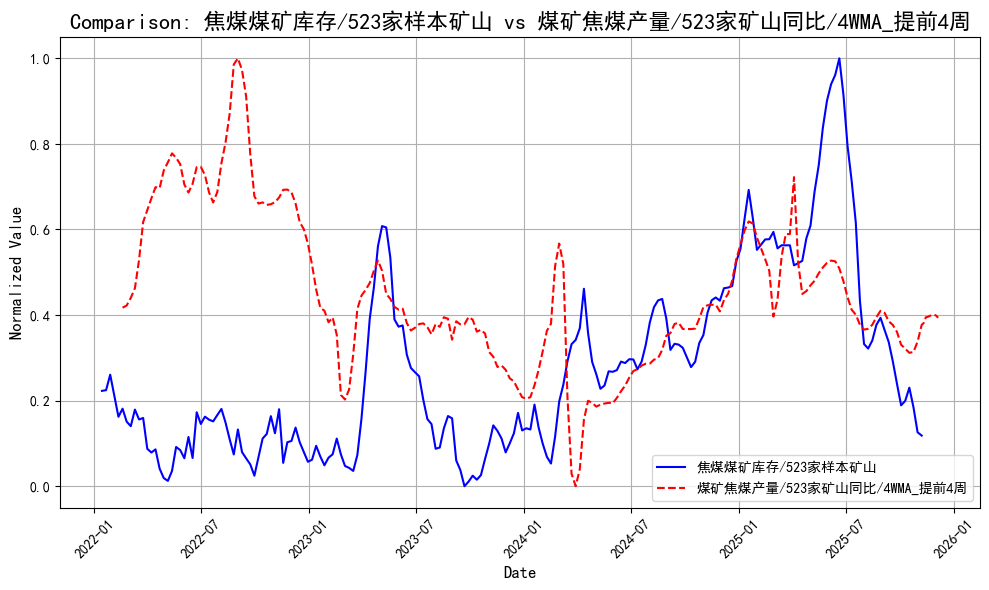

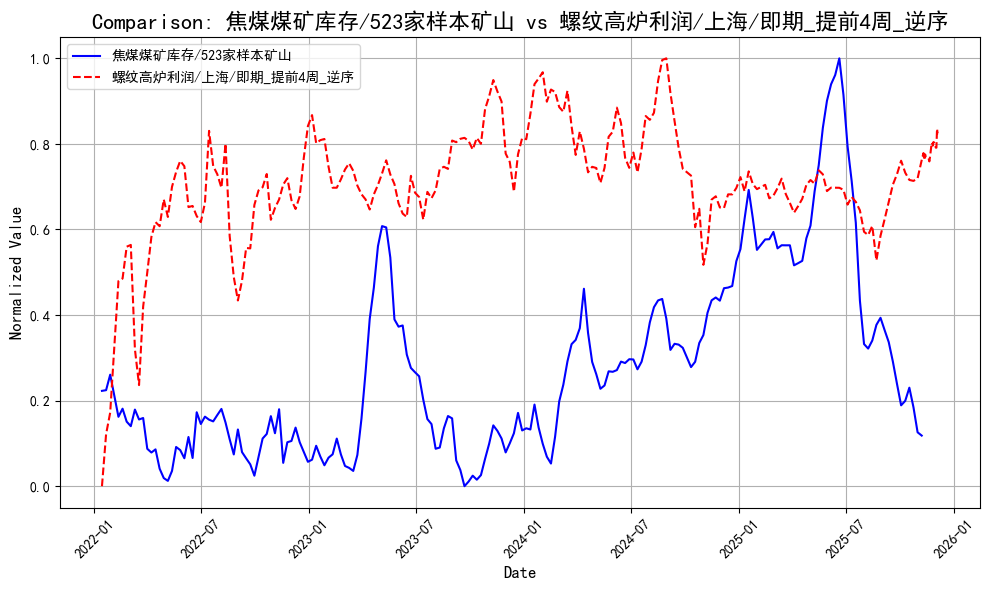

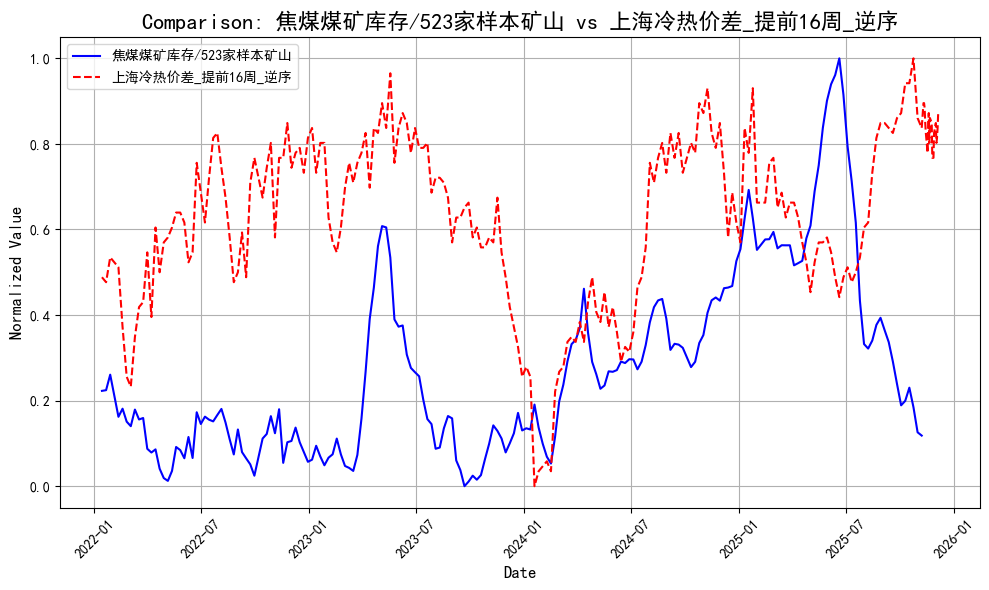

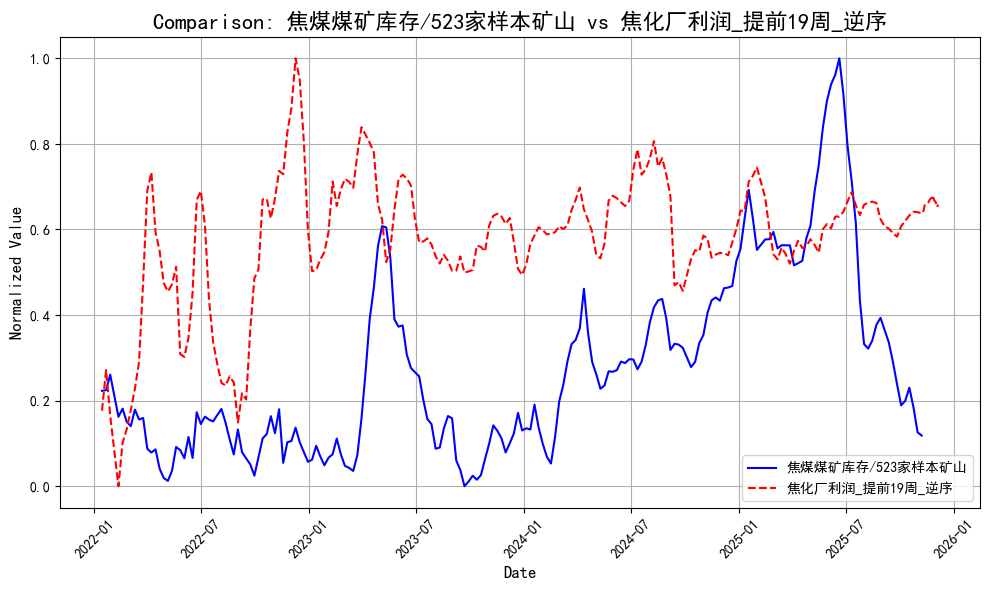

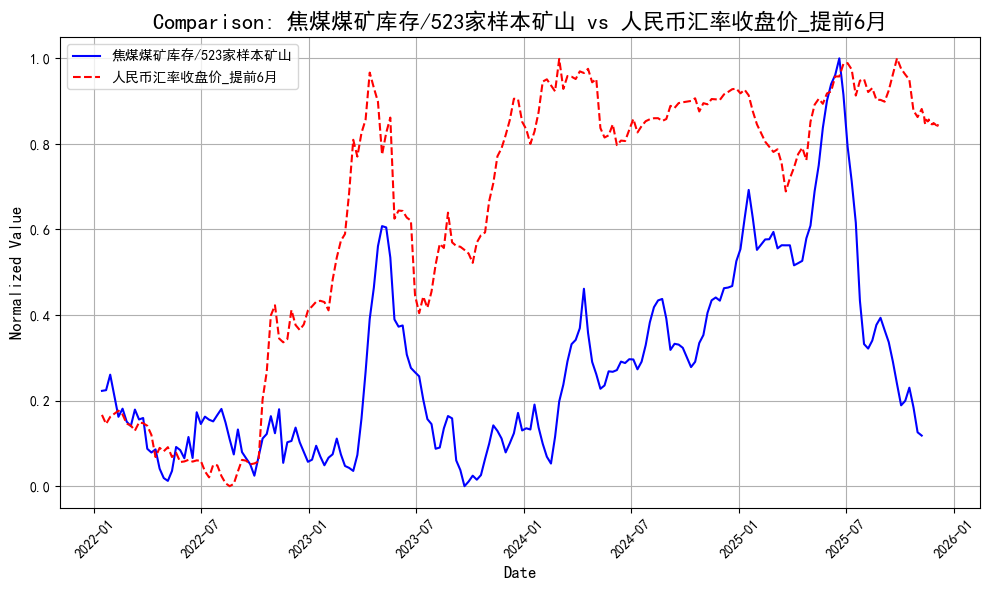

In [7]:

'''
sheet_daily['纯碱开工率（周度）noseasonal_平滑'] = sheet_daily['纯碱开工率（周度）noseasonal/F 0.1'].rolling(window=3, min_periods=1).mean()

sheet_daily['纯碱行业利润/周频_提前5周_平滑'] = sheet_daily['纯碱行业利润/周频_提前5周'].rolling(window=4, min_periods=1).mean()
sheet_daily['纯碱企业库存8周环差_提前8周_逆序_平滑'] = sheet_daily['纯碱企业库存8周环差_提前8周_逆序'].rolling(window=4, min_periods=1).mean()
'''
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='焦煤煤矿库存/523家样本矿山', 
    compare_cols=[
         '煤矿焦煤产量/523家矿山同比/4WMA_提前4周',
       '螺纹高炉利润/上海/即期_提前4周_逆序',
       '上海冷热价差_提前16周_逆序',
       '焦化厂利润_提前19周_逆序',
       '人民币汇率收盘价_提前6月'
       ]
)

In [8]:
# 对纯碱开工率数据进行平滑处理
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '煤矿焦煤产量/523家矿山同比/4WMA_提前4周',
    '螺纹高炉利润/上海/即期_提前4周_逆序',
    '上海冷热价差_提前16周_逆序',
    '焦化厂利润_提前19周_逆序',
    '人民币汇率收盘价_提前6月'
]
predict_column = '焦煤煤矿库存/523家样本矿山'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.03,  # 较小的学习率
    'max_depth':3,  # 控制树的深度防止过拟合
    'min_child_weight': 0.9,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0.05,  # 控制分裂
    'reg_alpha': 0.7,  # L1正则化
    'reg_lambda':0.9,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 1,
#    'tree_method': 'auto'
}


num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix




[0]	eval-rmse:124.80763	train-rmse:98.80350


[500]	eval-rmse:85.71627	train-rmse:11.03730


[1000]	eval-rmse:84.79425	train-rmse:4.56936


[1500]	eval-rmse:84.69235	train-rmse:2.25240


[1999]	eval-rmse:84.78212	train-rmse:1.17183


训练集 MSE (DMatrix): 1.5768, 训练集 R² (DMatrix): 0.9999
测试集 MSE (DMatrix): 7188.0077, 测试集 R² (DMatrix): 0.395


In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:99.97307


[500]	train-rmse:11.55835


[1000]	train-rmse:5.08547


[1500]	train-rmse:2.65807


[1999]	train-rmse:1.47342


全部数据 MSE: 2.4583, 全部数据 R²: 0.9998


Gap between last actual value and first prediction: -55.86957861328125


<Figure size 3000x800 with 0 Axes>

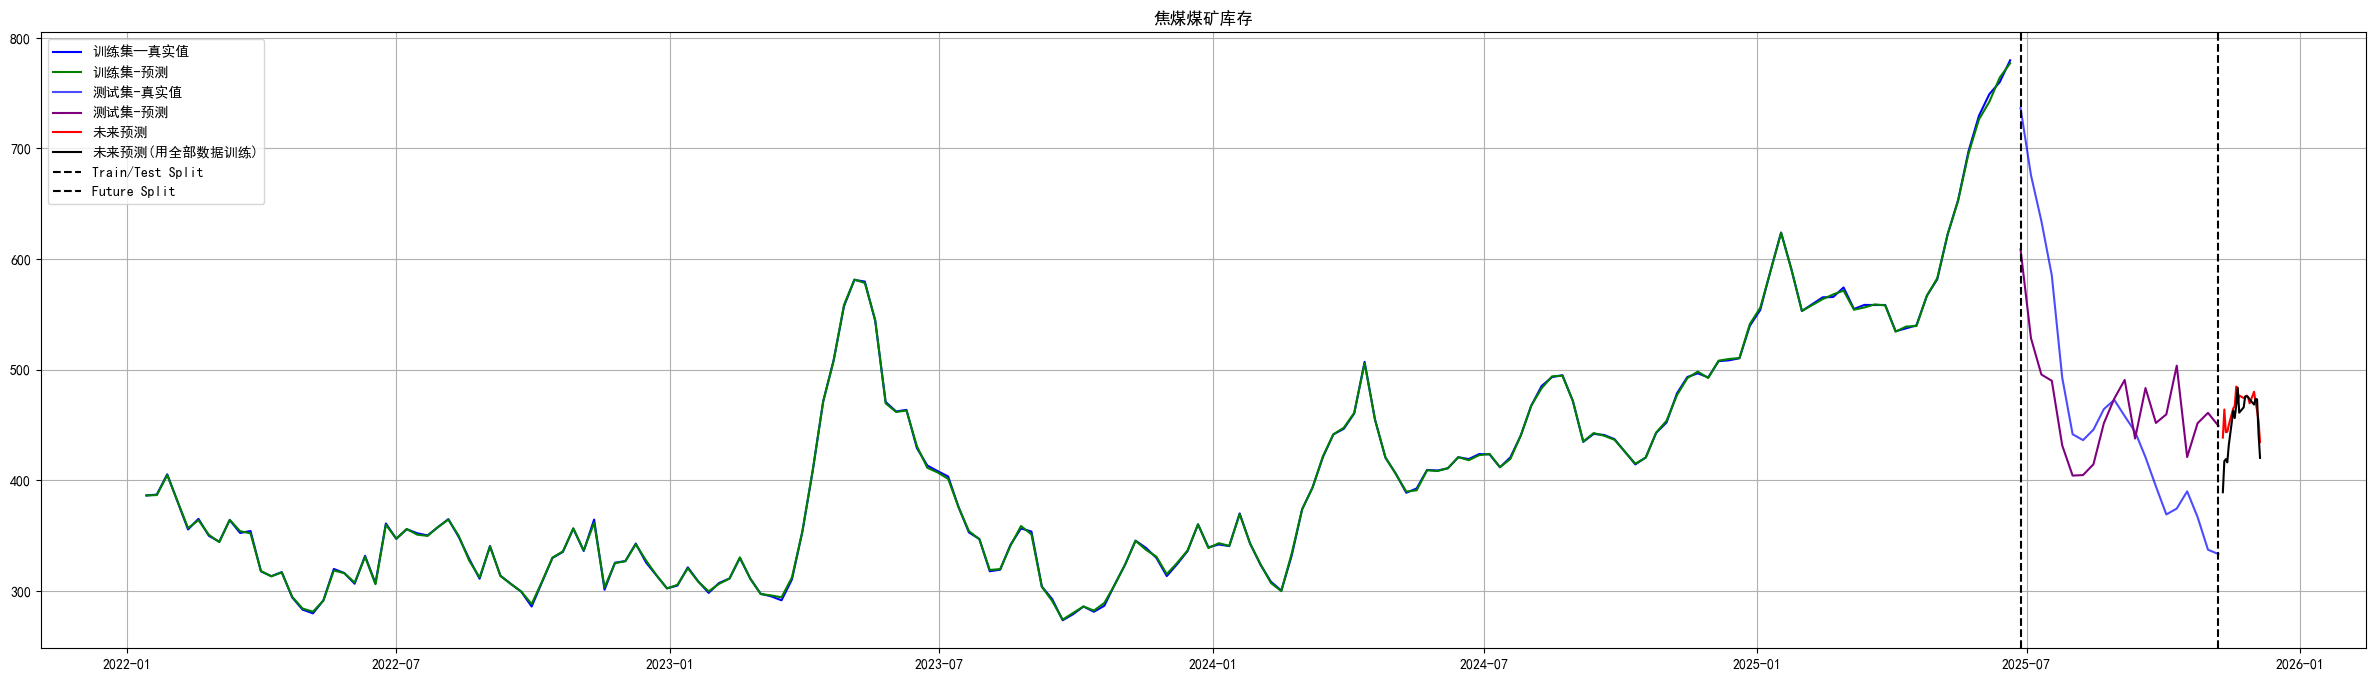

In [10]:
plt.figure(figsize=(30, 8))
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('焦煤煤矿库存')
plt.legend()
plt.grid(True)
plt.show()


---

---

In [11]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')

merged_df_daily.to_excel('eta/焦煤煤矿库存_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
166,2025/12/05,NaN,420.191315
165,2025/12/04,NaN,441.949341
164,2025/12/03,NaN,473.052856
163,2025/12/02,NaN,473.586700
162,2025/12/01,NaN,468.409058
...,...,...,...
4,2023/02/03,307.118,NaN
3,2023/01/27,298.156,NaN
2,2023/01/20,308.586,NaN
1,2023/01/13,321.224,NaN


In [12]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值':y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/焦煤煤矿库存_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,455.437836
34,2025/11/30,333.2860,451.294922
33,2025/10/31,367.4856,459.316986
32,2025/09/30,429.2645,465.882263
31,2025/08/31,452.1060,429.744537


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "焦煤煤矿库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "焦煤煤矿库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
